## Module 0: Data curation with an emphasis on pre-processing medical images
Please refer to lectures 2 & 3 from Module 0. \\
Questions: Laura Bell, bell.laura@gene.com


**Objectives (what will we learn here?)**


1.   Running a jupyter notebook in Google Colab
2.   Reading in high-resolution computed tomography (HRCT) NIfTI files, and saving the images as a numpy array
3.   Viewing slices of the HRCT lung volumes
4.   Applying a lung mask
5.   Re-sampling the spatial resolution of HRCT volume datasets


##Step 1: Set up the environment and determine where data is located

In [1]:
#Load packages that are needed to view & process the imaging data
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os

Connect to the data source:

In [2]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v1.4.0/gcsfuse_1.4.0_amd64.deb; \
    dpkg --install gcsfuse_1.4.0_amd64.deb; \
    apt-get update; \
    apt-get clean;

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,677 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,333 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-securi

In [6]:
from google.colab import auth
auth.authenticate_user()

In [4]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Are you sure you wish to set property [core/project] to sfsu-378805?

Do you want to continue (Y/n)?  Y

Updated property [core/project].


In [7]:
!gsutil ls

gs://csc-509-image-files/


In [8]:
!mkdir images

In [9]:
!gcsfuse --implicit-dirs csc-509-image-files images

{"time":"31/01/2024 06:33:40.878859","severity":"INFO","msg":"Start gcsfuse/1.4.0 (Go version go1.21.5) for app \"\" using mount point: /content/images\n"}


In [10]:
!ls images/

Archive				Module0_UPENNGBM       Module1_PET
Module0_DataCuration		Module1_BraTS	       Module2_ADNI
Module0_MRI_PET_Classification	Module1_BraTS.tar.bz2  Module2_ADNI_New


In [11]:
folder = '/content/images/Module0_DataCuration/'


Now that we have our folder with the imaging data, let's read it in and start playing with it!

There are four files in the folder named "Module0_DataCuration:
1.   subject001_BreathHoldX.nii.gz
2.   subject001_BreathHoldY.nii.gz
3.   subject001_BreathHoldX_LungMask.nii.gz
4.   subject001_BreathHoldY_LungMask.nii.gz

This is a single patient (patient ID 001) that have been acquired at two different breath holds: inspiration or expiration. There are two matching imaging datasets with just the lungs masked/segmented (more on this soon).

In [15]:
!ls images/Module0_DataCuration/ #list the files in the folder to ensure you see the four files mentioned

subject001_BreathHoldX_LungMask.nii.gz	subject001_BreathHoldY_LungMask.nii.gz
subject001_BreathHoldX.nii.gz		subject001_BreathHoldY.nii.gz


**Question 1: What is the file format of these imaging dataset?**


YOUR ANSWER: *fill in*

In [43]:
#let's read in the imaging datasets and start looking at the images!
subject001_X = nib.load(folder + 'subject001_BreathHoldX.nii.gz')
subject001_Y = nib.load(folder + 'subject001_BreathHoldY.nii.gz')

# this will separate out the imaging data from the header, and store it as a numpy array
subject001_X_volume = subject001_X.get_fdata()
subject001_Y_volume = subject001_Y.get_fdata()

# this will produce just the file header's information
subject001_X_header = subject001_X.header
subject001_Y_header = subject001_Y.header

image_voxeldimensions = subject001_X_header['pixdim'] #voxel dimensions in mm
image_dimensions = subject001_X_header['dim'] #image dimensions

# let's look at the shape of this matrix
print('The first index tells you the number of dimensions your image volume has. In this example, it is a {}D matrix'.format(image_dimensions[0]))
print('The reminder of the indices indicate the size of your matrix depending on the number of dimensions.')
print(image_dimensions)

# note that the header information should also match the size of the numpy array. let's check this!
print(subject001_X_volume.shape)

# let's also print the voxel dimensions
print(image_voxeldimensions) #note that you can ignore the first entry and note that the units here are in mm

The first index tells you the number of dimensions your image volume has. In this example, it is a 3D matrix
The reminder of the indices indicate the size of your matrix depending on the number of dimensions.
[  3 192 192 207   1   1   1   1]
(192, 192, 207)
[-1.  2.  2.  2.  0.  0.  0.  0.]


**Question 2: What size matrix is this dataset (e.g. 2D or 3D)? How many voxels are there? What is the spatial resolution?**



YOUR ANSWER: *fill in*

**Question 3: What is the field of view (check your units!)?**



YOUR ANSWER: *fill in*

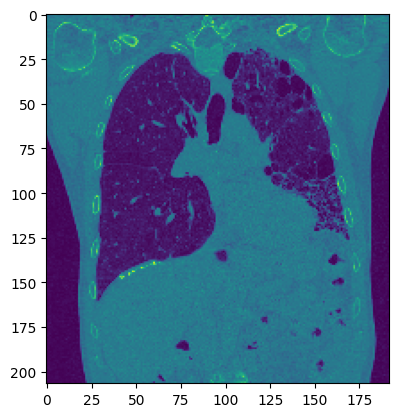

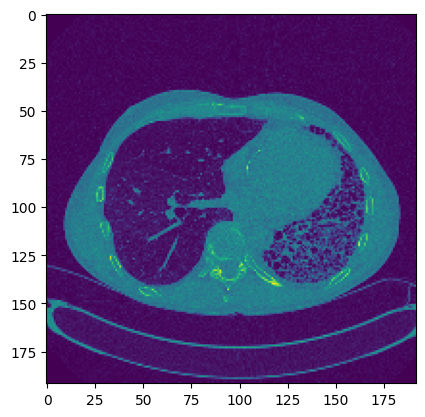

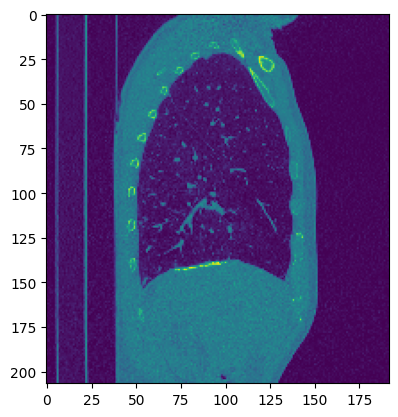

In [52]:
#let's view what these images look like!
sliceA_breathholdX = np.rot90(subject001_X_volume[:,98,:])
sliceB_breathholdX = np.rot90(subject001_X_volume[:,:,100])
sliceC_breathholdX = np.rot90(subject001_X_volume[63,:,:])


#let's view these three slices from this imaging volume
plt.imshow(sliceA_breathholdX)
plt.show()

plt.imshow(sliceB_breathholdX)
plt.show()

plt.imshow(sliceC_breathholdX)
plt.show()

**Question 4: What orientation are the three slices in?**

YOUR ANSWER:
1.   sliceA_breathholdX is in axial/coronal/sagittal orientation
2.   sliceB_breathholdX is in axial/coronal/sagittal orientation
3.   sliceC_breathholdX is in axial/coronal/sagittal orientation

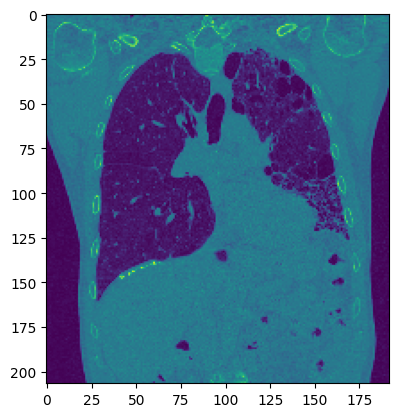

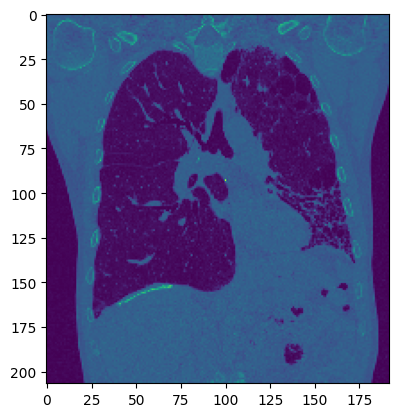

In [53]:
#let's now determine and label for the files for their breath hold
sliceA_breathholdX = np.rot90(subject001_X_volume[:,98,:])
sliceA_breathholdY = np.rot90(subject001_Y_volume[:,98,:])

plt.imshow(sliceA_breathholdX)
plt.show()

plt.imshow(sliceA_breathholdY)
plt.show()

**Question 5: Which file was acquired at inspiration? Expiration?**

YOUR ANSWER:

subject001_BreathHoldX.nii.gz was taken at inspiration/expiration

subject001_BreathHoldY.nii.gz was taken at inspiration/expiration

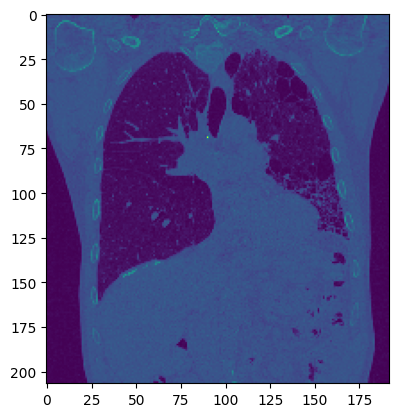

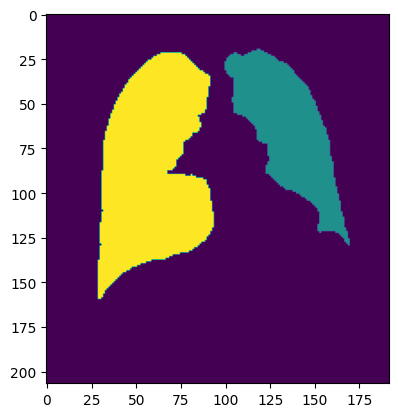

The unique values in the lung mask are [0. 1. 2.]


In [60]:
#now let's segment the lungs from the images
# if you're interested see this github link for an automatic AI model that will segment lungs from HRCTs: https://github.com/JoHof/lungmask

# for today's exercise, the lungs have already been segmented for you and saved as additional files in the folder
subject001_X_lungmask = nib.load(folder + 'subject001_BreathHoldX_LungMask.nii.gz').get_fdata()

sliceA_breathholdX = np.rot90(subject001_X_volume[:,100,:])
sliceA_breathholdY_lungmask = np.rot90(subject001_X_lungmask[:,100,:])

plt.imshow(sliceA_breathholdX)
plt.show()

plt.imshow(sliceA_breathholdY_lungmask)
plt.show()

# what are the values in the lung mask?
print('The unique values in the lung mask are {}'.format(np.unique(sliceA_breathholdY_lungmask)))


**Question 6: What do you think the different colors represent in this lung mask? Do you think it did a good job at segmenting the lungs?**

YOUR ANSWER: fill in

**Question 7: Can you build a pre-processing pipeline?**
For this question, you will need to fill in the code for the following 3 cells that will:
1.   segment the lungs
2.   resample the resolution to 4 x 4 x 4 mm^3
3.   normalize the pixel values from 0 to 1

In [ ]:
# Question 7, part 1: segment the lungs
# HINT: right now the lung mask holds 3 unique values 0, 1, 2.
# First, change this so everything that is not lung is 0 and everything that is lung is 1
# Second, multiple the two numpy arrays together such that you only lung tissue in the end


# FILL IN YOUR CODE

In [ ]:
# Question 7, part 2: resample the resolution to 4 x 4 x 4 mm^3
# HINT: use the zoom function from scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html#scipy.ndimage.zoom

# FILL IN YOUR CODE

In [ ]:
# Question 7, part 3: normalize the pixel values from 0 to 1
# HINT: Find the min and max pixel values to scale accordingly

# FILL IN YOUR CODE